# Temperature Scaling vs. Confidence Penalty

Pereyra et al. link label smoothing [Szegedy2016] to *confidence penalty* (CP) and propose a simple way to prevent over-confident networks [Pereyra2017].
Low entropy output distributions are penalized by adding the negative entropy $ \mathcal{H} $ of the softmax output to the negative log-likelihood training objective, weighted by an additional hyperparameter $ \beta $.
This leads to the following optimization function:

$ \mathcal{L}_{\mathrm{CP}}(\mathbf{w}) = - \sum_{\mathcal{X}, \mathcal{Y}} \log \mathbf{p}_{\mathbf{w}} (\mathbf{y} \vert \mathbf{x}) - \beta \, \mathcal{H} \left( \mathbf{p}_{\mathbf{w}}(\mathbf{y} \vert \mathbf{x}) \right) ~ . $

We reproduce their experiment on supervised image classification and compare the calibratedness of confidence and uncertainty to our presented approach.
DenseNet-121 with dropout is trained on CIFAR-10 as described in § A.3.
We fix $ \beta = 0.1 $ for CP loss and omit data augmentation for this experiment as described in [Pereyra2017].

In [1]:
%matplotlib notebook
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
from tqdm import tqdm
from ece import eceloss, uceloss
from utils import accuracy, nentr
from models import BayesianNet
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 8

In [2]:
batch_size = 128
valid_size = 5000

mean = [0.4914, 0.48216, 0.44653]
std = [0.2470, 0.2435, 0.26159]
valid_set = datasets.CIFAR10('../data', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.RandomCrop(32, padding=4),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=mean, std=std)]))

test_set = datasets.CIFAR10('../data', train=False, download=False,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)]))
valid_indices = torch.load('./valid_indices_cifar10.pth')

valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, pin_memory=True,
                                           sampler=SubsetRandomSampler(valid_indices))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified


In [3]:
conf_penalty_net = BayesianNet(num_classes=10, model='densenet121').to(device)
temp_scale_net = BayesianNet(num_classes=10, model='densenet121').to(device)

conf_penalty_checkpoint = torch.load(f'../snapshots/densenet121_best_cp.pth.tar', map_location=device)
print("Loading previous weights at epoch " + str(conf_penalty_checkpoint['epoch']))
conf_penalty_net.load_state_dict(conf_penalty_checkpoint['state_dict'])

temp_scale_checkpoint = torch.load(f'../snapshots/densenet121_best_no_cp.pth.tar', map_location=device)
print("Loading previous weights at epoch " + str(temp_scale_checkpoint['epoch']))
temp_scale_net.load_state_dict(temp_scale_checkpoint['state_dict'])

Loading previous weights at epoch 162
Loading previous weights at epoch 170


<All keys matched successfully>

In [4]:
def train(net, bayesian):
    optimizer = optim.Adam([net.T], lr=1e-2, weight_decay=0)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1)
    train_losses = []
    train_accuracies = []
    epochs = 30

    for e in range(epochs):
        net.eval()

        epoch_train_loss = []
        epoch_train_acc = []
        is_best = False

        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data, temp_scale=True, bayesian=bayesian)
            if bayesian:
                output = torch.log_softmax(output, dim=2)
                output = output.mean(dim=0)
                loss = F.nll_loss(output, target)
            else:
                loss = F.cross_entropy(output, target)
            loss.backward()
            epoch_train_loss.append(loss.item())
            epoch_train_acc.append(accuracy(output, target))
            optimizer.step()

        epoch_train_loss = np.mean(epoch_train_loss)
        epoch_train_acc = np.mean(epoch_train_acc)
        lr_scheduler.step(epoch_train_loss)

        # save epoch losses
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        print("Epoch {:2d}, lr: {:.4f}, loss: {:.4f}, acc: {:.4f}, T: {:.4f}"
              .format(e,
                      optimizer.param_groups[0]['lr'],
                      epoch_train_loss,
                      epoch_train_acc,
                      net.T.item()
                      ))

In [5]:
# train(conf_penalty_net, bayesian=True)
train(temp_scale_net, bayesian=True)

Epoch  0, lr: 0.0100, loss: 0.4800, acc: 0.8518, T: 1.3314
Epoch  1, lr: 0.0100, loss: 0.4507, acc: 0.8578, T: 1.5089
Epoch  2, lr: 0.0100, loss: 0.4384, acc: 0.8654, T: 1.5890
Epoch  3, lr: 0.0100, loss: 0.4529, acc: 0.8477, T: 1.6101
Epoch  4, lr: 0.0100, loss: 0.4481, acc: 0.8547, T: 1.6431
Epoch  5, lr: 0.0100, loss: 0.4671, acc: 0.8430, T: 1.6763
Epoch  6, lr: 0.0100, loss: 0.4550, acc: 0.8533, T: 1.6822
Epoch  7, lr: 0.0100, loss: 0.4446, acc: 0.8568, T: 1.6605
Epoch  8, lr: 0.0010, loss: 0.4624, acc: 0.8414, T: 1.6657
Epoch  9, lr: 0.0010, loss: 0.4419, acc: 0.8584, T: 1.6622
Epoch 10, lr: 0.0010, loss: 0.4393, acc: 0.8535, T: 1.6569
Epoch 11, lr: 0.0010, loss: 0.4520, acc: 0.8529, T: 1.6555
Epoch 12, lr: 0.0010, loss: 0.4676, acc: 0.8527, T: 1.6580
Epoch 13, lr: 0.0010, loss: 0.4522, acc: 0.8520, T: 1.6608
Epoch 14, lr: 0.0001, loss: 0.4628, acc: 0.8518, T: 1.6601
Epoch 15, lr: 0.0001, loss: 0.4466, acc: 0.8564, T: 1.6604
Epoch 16, lr: 0.0001, loss: 0.4474, acc: 0.8539, T: 1.66

In [6]:
def test(net, temp_scale, bayesian):
    logits = []
    labels = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
            data, target = data.to(device), target.to(device)
            output = net(data, temp_scale=temp_scale, bayesian=bayesian)
            if bayesian:
                output = torch.softmax(output, dim=2).mean(dim=0)
            else:
                output = torch.softmax(output, dim=1)
            logits.append(output.detach())
            labels.append(target.detach())
    return torch.cat(logits, dim=0), torch.cat(labels, dim=0)

In [7]:
def plot_conf(acc, conf):
    fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.25))
    ax.plot([0,1], [0,1], 'k--')
    ax.plot(conf.data.cpu().numpy(), acc.data.cpu().numpy(), marker='.')
    ax.set_xlabel(r'confidence')
    ax.set_ylabel(r'accuracy')
    ax.set_xticks((np.arange(0, 1.1, step=0.2)))
    ax.set_yticks((np.arange(0, 1.1, step=0.2)))

    return fig, ax

def plot_uncert(err, entr):
    fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.25))
    
    ax.plot([0,1], [0,1], 'k--') 
    ax.plot(entr.data.cpu().numpy(), err.data.cpu().numpy(), marker='.')
    ax.set_xticks((np.arange(0, 1.1, step=0.2)))
    ax.set_ylabel(r'error')
    ax.set_xlabel(r'uncertainty')
    ax.set_xticks((np.arange(0, 1.1, step=0.2)))
    ax.set_yticks((np.arange(0, 1.1, step=0.2)))

    return fig, ax

100%|██████████| 79/79 [00:01<00:00, 52.92it/s]

ece = 3.3679887652397156


<IPython.core.display.Javascript object>


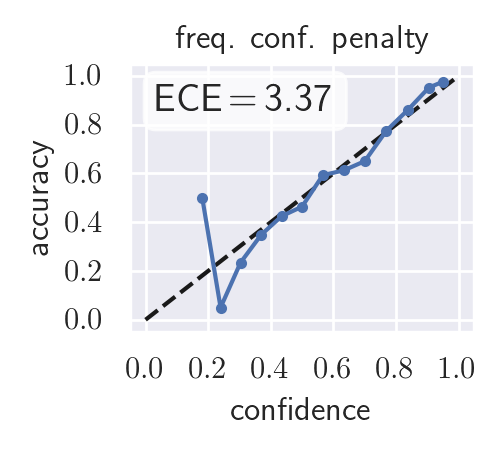

In [8]:
logits, labels = test(conf_penalty_net, temp_scale=False, bayesian=False)

ece_cp_uc, acc_cp_uc, conf_cp_uc = eceloss(logits, labels)
print('ece =', ece_cp_uc.item()*100)

fig_cp_uc, ax_cp_uc = plot_conf(acc_cp_uc, conf_cp_uc)

textstr_cp_uc = r'ECE\,=\,{:.2f}'.format(ece_cp_uc.item()*100)
props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax_cp_uc.text(0.075, 0.925, textstr_cp_uc, transform=ax_cp_uc.transAxes, fontsize=14,
                verticalalignment='top',
                horizontalalignment='left',
                bbox=props
                )
ax_cp_uc.set_title(r'freq. conf. penalty')
fig_cp_uc.tight_layout()
fig_cp_uc.show()

100%|██████████| 79/79 [00:01<00:00, 50.54it/s]

ece = 4.853932932019234
uce = 15.204653143882751


<IPython.core.display.Javascript object>


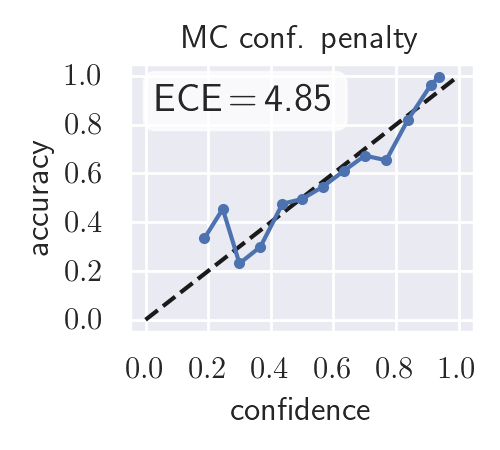

<IPython.core.display.Javascript object>


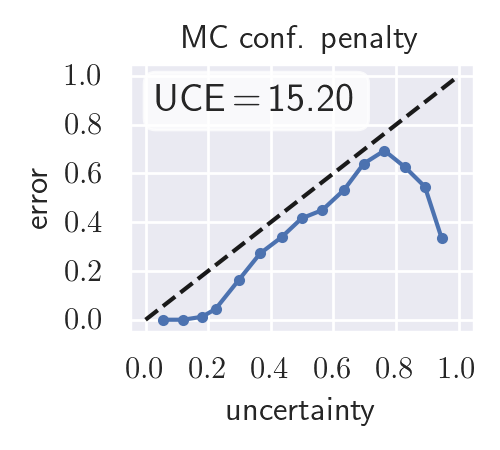

In [9]:
logits, labels = test(conf_penalty_net, temp_scale=False, bayesian=True)

ece1, acc1, conf1 = eceloss(logits, labels)
uce1, err1, entr1 = uceloss(logits, labels)

print('ece =', ece1.item()*100)
print("uce =", uce1.item()*100)

fig1, ax1 = plot_conf(acc1, conf1)
fig2, ax2 = plot_uncert(err1, entr1)

textstr1 = r'ECE\,=\,{:.2f}'.format(ece1.item()*100)
props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax1.text(0.075, 0.925, textstr1, transform=ax1.transAxes, fontsize=14,
         verticalalignment='top',
         horizontalalignment='left',
         bbox=props
        )
ax1.set_title(r'MC conf. penalty')
fig1.tight_layout()
fig1.show()

textstr2 = r'UCE\,=\,{:.2f}'.format(uce1.item()*100)
ax2.text(0.075, 0.925, textstr2, transform=ax2.transAxes, fontsize=14,
         verticalalignment='top',
         horizontalalignment='left',
         bbox=props
        )
ax2.set_title(r'MC conf. penalty')
fig2.tight_layout()
fig2.show()

100%|██████████| 79/79 [00:01<00:00, 40.46it/s]

ece = 1.0747364722192287


<IPython.core.display.Javascript object>


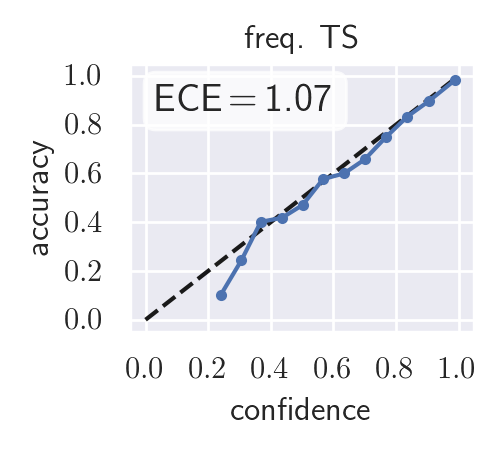

In [10]:
logits, labels = test(temp_scale_net, temp_scale=True, bayesian=False)

ece_freq_ts, acc_freq_ts, conf_freq_ts = eceloss(logits, labels)
print('ece =', ece_freq_ts.item()*100)

fig_ts_uc, ax_ts_uc = plot_conf(acc_freq_ts, conf_freq_ts)

textstr_freq_ts = r'ECE\,=\,{:.2f}'.format(ece_freq_ts.item()*100)
props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax_ts_uc.text(0.075, 0.925, textstr_freq_ts, transform=ax_ts_uc.transAxes, fontsize=14,
                verticalalignment='top',
                horizontalalignment='left',
                bbox=props
                )
ax_ts_uc.set_title(r'freq. TS')
fig_ts_uc.tight_layout()
fig_ts_uc.show()

100%|██████████| 79/79 [00:02<00:00, 38.91it/s]

ece = 0.6901661865413189
uce = 3.8130737841129303


<IPython.core.display.Javascript object>


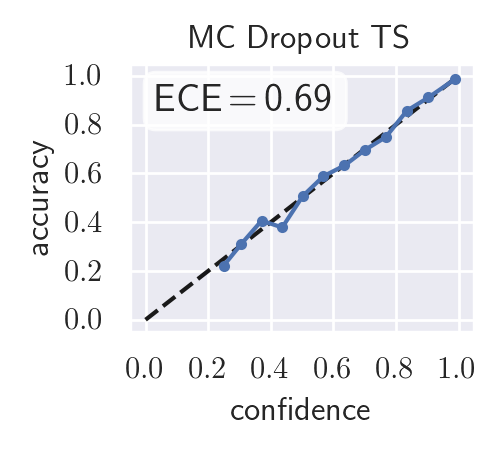

<IPython.core.display.Javascript object>


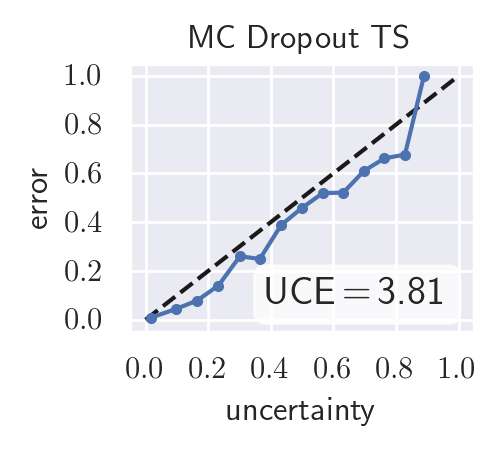

In [11]:
logits2, labels2 = test(temp_scale_net, temp_scale=True, bayesian=True)

ece2, acc2, conf2 = eceloss(logits2, labels2)
uce2, err2, entr2 = uceloss(logits2, labels2)

print('ece =', ece2.item()*100)
print("uce =", uce2.item()*100)

fig3, ax3 = plot_conf(acc2, conf2)
fig4, ax4 = plot_uncert(err2, entr2)

textstr3 = r'ECE\,=\,{:.2f}'.format(ece2.item()*100)
props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax3.text(0.075, 0.925, textstr3, transform=ax3.transAxes, fontsize=14,
        verticalalignment='top',
        horizontalalignment='left',
        bbox=props
        )
ax3.set_title(r'MC Dropout TS')
fig3.tight_layout()
fig3.show()

textstr4 = r'UCE\,=\,{:.2f}'.format(uce2.item()*100)
ax4.text(0.925, 0.075, textstr4, transform=ax4.transAxes, fontsize=14,
         verticalalignment='bottom',
         horizontalalignment='right',
         bbox=props
         )
ax4.set_title(r'MC Dropout TS')
fig4.tight_layout()
fig4.show()

<IPython.core.display.Javascript object>


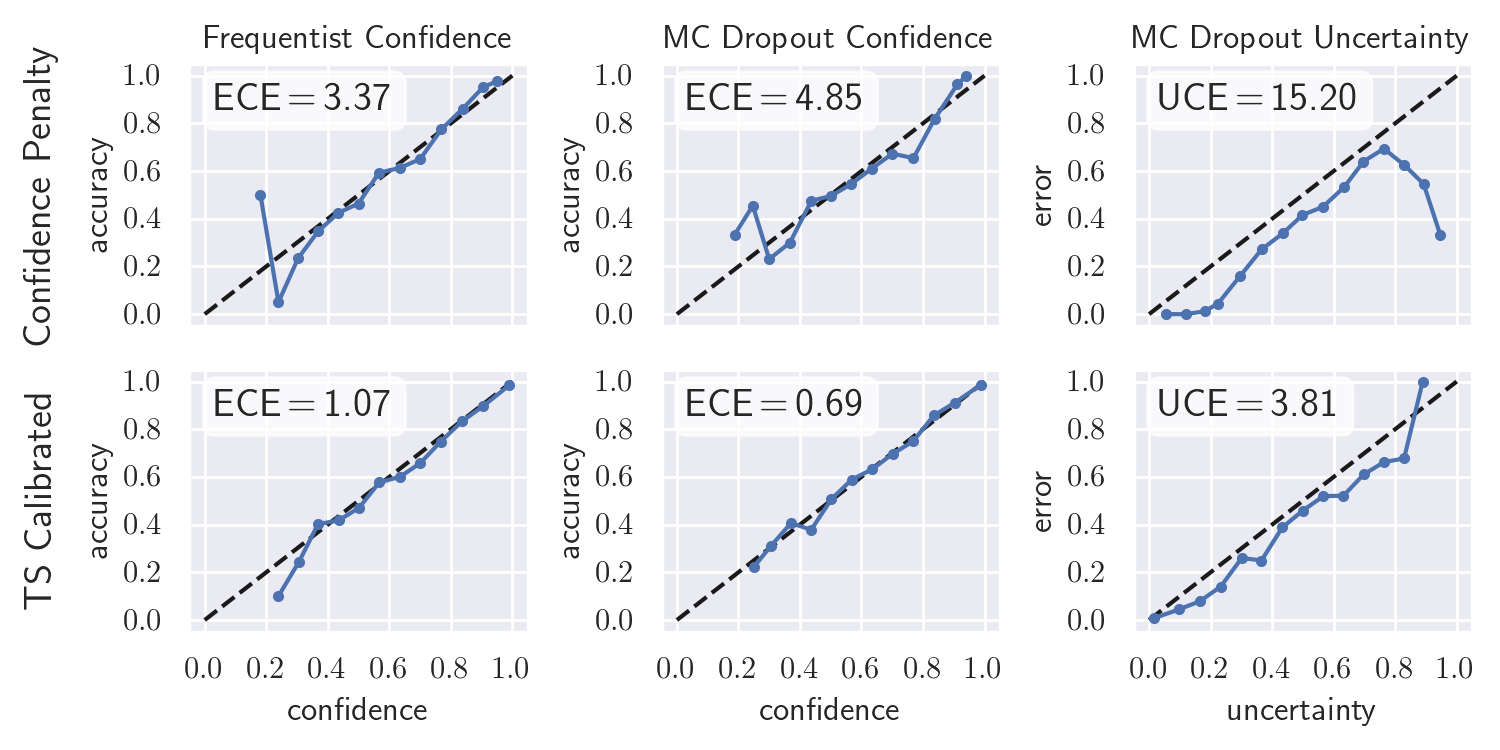

In [12]:
# compose final figure
fig_uc, ax_uc = plt.subplots(2, 3, figsize=(7.5, 3.75), sharex=True, sharey=False)

ax_uc[0,0].plot([0,1], [0,1], 'k--')
ax_uc[0,0].plot(conf_cp_uc.data.cpu().numpy(), acc_cp_uc.data.cpu().numpy(), marker='.')
#ax_uc[0,0].set_xlabel(r'confidence')
ax_uc[0,0].set_ylabel(r'accuracy')
ax_uc[0,0].set_xticks((np.arange(0, 1.1, step=0.2)))
ax_uc[0,0].set_yticks((np.arange(0, 1.1, step=0.2)))
ax_uc[0,0].set_title(r'Frequentist Confidence')
ax_uc[0,0].text(0.075, 0.925, textstr_cp_uc, transform=ax_uc[0,0].transAxes, fontsize=14,
                verticalalignment='top',
                horizontalalignment='left',
                bbox=props
                )

ax_uc[0,1].plot([0,1], [0,1], 'k--')
ax_uc[0,1].plot(conf1.data.cpu().numpy(), acc1.data.cpu().numpy(), marker='.')
ax_uc[0,1].set_xticks((np.arange(0, 1.1, step=0.2)))
ax_uc[0,1].set_yticks((np.arange(0, 1.1, step=0.2)))
ax_uc[0,1].set_ylabel(r'accuracy')
#ax_uc[0,1].set_xlabel(r'confidence')
ax_uc[0,1].set_title(r'MC Dropout Confidence')
ax_uc[0,1].text(0.075, 0.925, textstr1, transform=ax_uc[0,1].transAxes, fontsize=14,
                verticalalignment='top',
                horizontalalignment='left',
                bbox=props
                )

ax_uc[0,2].plot([0,1], [0,1], 'k--')
ax_uc[0,2].plot(entr1.data.cpu().numpy(), err1.data.cpu().numpy(), marker='.')
ax_uc[0,2].set_xticks((np.arange(0, 1.1, step=0.2)))
ax_uc[0,2].set_yticks((np.arange(0, 1.1, step=0.2)))
ax_uc[0,2].set_ylabel(r'error')
#ax_uc[0,2].set_xlabel(r'uncertainty')
ax_uc[0,2].set_title(r'MC Dropout Uncertainty')
ax_uc[0,2].text(0.075, 0.925, textstr2, transform=ax_uc[0,2].transAxes, fontsize=14,
                verticalalignment='top',
                horizontalalignment='left',
                bbox=props
                )


ax_uc[0,0].annotate(r'Confidence Penalty', xy=(0, 0.5), xytext=(-ax_uc[0,0].yaxis.labelpad - 5, 0),
                    xycoords=ax_uc[0,0].yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center', fontsize=14, rotation=90)


ax_uc[1,0].plot([0,1], [0,1], 'k--')
ax_uc[1,0].plot(conf_freq_ts.data.cpu().numpy(), acc_freq_ts.data.cpu().numpy(), marker='.')
ax_uc[1,0].set_xlabel(r'confidence')
ax_uc[1,0].set_ylabel(r'accuracy')
ax_uc[1,0].set_xticks((np.arange(0, 1.1, step=0.2)))
ax_uc[1,0].set_yticks((np.arange(0, 1.1, step=0.2)))
#ax_uc[1,0].set_title(r'frequentist')
ax_uc[1,0].text(0.075, 0.925, textstr_freq_ts, transform=ax_uc[1,0].transAxes, fontsize=14,
                verticalalignment='top',
                horizontalalignment='left',
                bbox=props
                )

ax_uc[1,1].plot([0,1], [0,1], 'k--')
ax_uc[1,1].plot(conf2.data.cpu().numpy(), acc2.data.cpu().numpy(), marker='.')
ax_uc[1,1].set_xticks((np.arange(0, 1.1, step=0.2)))
ax_uc[1,1].set_yticks((np.arange(0, 1.1, step=0.2)))
ax_uc[1,1].set_ylabel(r'accuracy')
ax_uc[1,1].set_xlabel(r'confidence')
#ax_uc[1,1].set_title(r'MC dropout')
ax_uc[1,1].text(0.075, 0.925, textstr3, transform=ax_uc[1,1].transAxes, fontsize=14,
                verticalalignment='top',
                horizontalalignment='left',
                bbox=props
                )

ax_uc[1,2].plot([0,1], [0,1], 'k--')
ax_uc[1,2].plot(entr2.data.cpu().numpy(), err2.data.cpu().numpy(), marker='.')
ax_uc[1,2].set_xticks((np.arange(0, 1.1, step=0.2)))
ax_uc[1,2].set_yticks((np.arange(0, 1.1, step=0.2)))
ax_uc[1,2].set_ylabel(r'error')
ax_uc[1,2].set_xlabel(r'uncertainty')
#ax_uc[1,2].set_title(r'MC dropout')
ax_uc[1,2].text(0.075, 0.925, textstr4, transform=ax_uc[1,2].transAxes, fontsize=14,
                verticalalignment='top',
                horizontalalignment='left',
                bbox=props
                )

ax_uc[1,0].annotate(r'TS Calibrated', xy=(0, 0.5), xytext=(-ax_uc[1,0].yaxis.labelpad - 5, 0),
                    xycoords=ax_uc[1,0].yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center', fontsize=14, rotation=90)

fig_uc.tight_layout()
fig_uc.show()
fig_uc.savefig(f'conf_penalty_composed.pdf', bbox_inches='tight', pad_inches=0)